
$$c_{obs}=\sum_{i}\int_{0}^{T}p_{i}(x,t)\mathrm{d}t$$
$$c_{ctrl}=\int_{0}^{T}U^TRU\mathrm{d}t$$
$$c_{end}=\Vert x(T)-x_{goal} \Vert _2$$
$$\dot{X}=f(X,U)$$
$$X(0)=X_{init}$$
$$X_{lb}\le X\le X_{ub}$$

* 离散化
$$c_{obs}=\sum_{i} \sum_{k=1}^{N}p_{i,k}(x_{k})$$
$$p_{i,k}=N(\hat{o}_{i,k}, \Sigma_{i,k})$$


In [1]:
import casadi as ca
import numpy as np

In [2]:
p_var = ca.SX.sym('variance', 2,2)
p_mean = ca.SX.sym('mean', 2,1)
x = ca.SX.sym('x', 2,1)
p_k = 1/(2*np.pi)/ca.sqrt(ca.det(p_var))
p = p_k*ca.exp( -(x-p_mean).T @ ((ca.inv(p_var))@(x-p_mean))/2 )

gauss_f = ca.Function('guassian_f', [x, p_mean, p_var], [p], ['variable', 'mean', 'variance'], ['density'])

$\dot{x}=v$, $\dot{v}=u$

state:[$x,\dot{x}$], input:$u

In [3]:
dt = 0.1

px, py = ca.SX.sym('px'), ca.SX.sym('py')
vx, vy = ca.SX.sym('vx'), ca.SX.sym('vy')
X = ca.vertcat(px, py, vx, vy)

ux, uy = ca.SX.sym('ux'), ca.SX.sym('uy')
U = ca.vertcat(ux, uy)

X_next = [px+vx*dt,
          py+vy*dt,
          vx+ux*dt,
          vy+uy*dt]
X_next = ca.vertcat(*X_next)

dynamic_f = ca.Function('dynamic_f', [X, U], [X_next], ['state', 'input'], ['input'])


Variables for Optimation: $\{u_{k},x_{k}\}_{k=1,...,N}$

Parameters: $x_{init}$, $\{o_{k}, \Sigma_{k}\}_{k=1,...,N}$, $x_{goal}$

In [4]:
kcobs, kcc, kce = 1, 1, 1
R = ca.diag([0.1, 0.1])
nlp_f = 0
nlp_x = []
nlp_g = []

X = ca.SX.sym('X', 4, 10)
U = ca.SX.sym('U', 2, 10)
P = ca.SX.sym('param', 4+6*10+2)

nlp_f += U[:,0].T@R@U[:,0]
nlp_f += gauss_f(X[:2,0], P[4:6], ca.reshape(P[6:10], 2,2))
nlp_x += [U[:,0], X[:,0]]
nlp_g += [X[:,0] - dynamic_f(P[0:4],U[:,0])]

for i in range(1,10):
    nlp_f += U[:,i].T@R@U[:,i]
    nlp_f += gauss_f(X[:2,i], P[4+i*6:6+i*6], ca.reshape(P[6+i*6:10+i*6], 2,2))
    nlp_x += [U[:,i], X[:,i]]
    nlp_g += [X[:,i] - dynamic_f(X[:,i-1],U[:,i])]

nlp_f += ca.norm_2(X[:2,i]-P[-2:])

nlp_dict = {
    'f': nlp_f,
    'x': ca.veccat(*nlp_x),
    'p': P,
    'g': ca.veccat(*nlp_g)
}
nlp_ipopt_option = {
    'verbose': False,
    # 'ipopt.acceptable_tol': 1e-2,
    'ipopt.tol': 1e-4,
    'ipopt.max_iter': 500,
    # 'ipopt.warm_start_init_point': 'yes',
    'ipopt.bound_push': 1e-8,
    'ipopt.bound_frac': 1e-8,
    # 'ipopt.linear_solver': 'ma27'
    # 'ipopt.print_level': 0,
    # 'print_time': False,
    'ipopt.mu_strategy': 'adaptive'
}
nlp_solver = ca.nlpsol('solver', 'ipopt', nlp_dict, nlp_ipopt_option)

In [5]:
x0 = [0 for i in range(60)]
lbx, ubx = [],[]
lbg, ubg = [],[]
for i in range(10):
    lbx += [-2,-2, -ca.inf,-ca.inf, -2,-2]
    ubx += [ 2, 2,  ca.inf, ca.inf,  2, 2]
    lbg += [0, 0, 0, 0]
    ubg += [0, 0, 0, 0]

def nlp_solve(P):
    global x0
    
    sol = nlp_solver(x0=x0,
                     lbx=lbx,
                     ubx=ubx,
                     lbg=lbg,
                     ubg=ubg,
                     p=P)
    return sol

In [26]:
p = np.zeros(4+6*10+2)

x_init = np.array([2,0,0,0])
x_goal = np.array([2, 5])
obs_p = np.array([2.2, 1])
obs_var = np.array([[0.1, 0],
                    [0, 0.1]])


p[:4] = x_init
for i in range(10):
    p[4+i*6:6+i*6] = obs_p
    p[6+i*6:10+i*6] = obs_var.T.reshape(4)

p[-2:] = x_goal

In [27]:
res = nlp_solve(p)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      114
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       50

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:       40
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [28]:
X = np.array(res['x'])
pos = np.zeros([2,10])
for i in range(10):
    pos[0,i] = X[2+i*6]
    pos[1,i] = X[3+i*6]

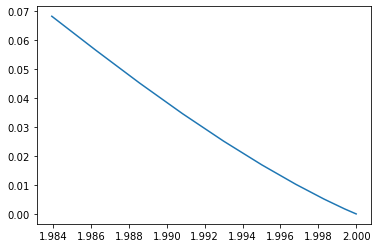

In [29]:
import matplotlib.pyplot as plt
plt.plot(pos[0,:], pos[1,:])